In [1]:
] activate ../

  Activating project at `/dfs6/pub/ikeshwan/code/HorizontalConvection`


In [1]:
] status

Status `/dfs6/pub/ikeshwan/code/HorizontalConvection/Project.toml`
⌃ [13f3f980] CairoMakie v0.10.10
  [7073ff75] IJulia v1.24.2
⌃ [b946abbf] NaNStatistics v0.6.31
⌃ [9e8cae18] Oceananigans v0.88.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [1]:
using Oceananigans
#using Printf

In [2]:
Nx = 128
Nz = 64
L = 10
H = 10
grid = RectilinearGrid(size=(Nx, Nz), x=(-L/2, L/2), z=(-H/2, H/2),
                       topology=(Periodic, Flat, Bounded))

128×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── Periodic x ∈ [-5.0, 5.0)      regularly spaced with Δx=0.078125
├── Flat y
└── Bounded  z ∈ [-5.0, 5.0]      regularly spaced with Δz=0.15625

In [3]:
shear_flow(x, y, z, t) = tanh(z)

stratification(x, y, z, t, p) = p.h * p.Ri * tanh(z / p.h)

U = BackgroundField(shear_flow)

B = BackgroundField(stratification, parameters=(Ri=0.1, h=1/4));

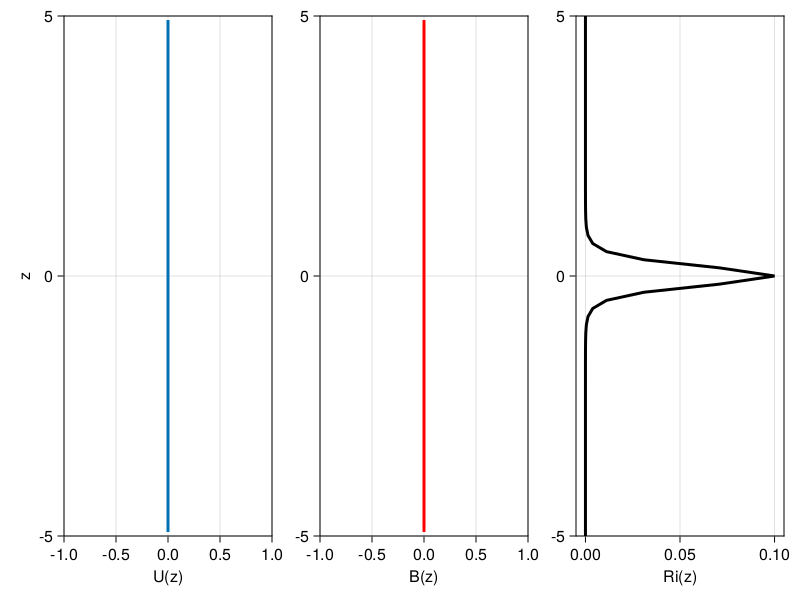

In [4]:
using CairoMakie

zF = znodes(grid, Face())
zC = znodes(grid, Center())

Ri, h = B.parameters

fig = Figure(size = (850, 450))

ax = Axis(fig[1, 1], xlabel = "U(z)", ylabel = "z", limits=((nothing, nothing), (-5, 5)))
lines!(ax, shear_flow.(0, zC, 0, 0), zC; linewidth = 3)

ax = Axis(fig[1, 2], xlabel = "B(z)", limits=((nothing, nothing), (-5, 5)))
lines!(ax, [stratification(0, z, 0, 0, (Ri=Ri, h=h)) for z in zC], zC; linewidth = 3, color = :red)

ax = Axis(fig[1, 3], xlabel = "Ri(z)", limits=((nothing, nothing), (-5, 5)))
lines!(ax, [Ri * sech(z / h)^2 / sech(z)^2 for z in zF], zF; linewidth = 3, color = :black) # Ri(z)= ∂_z B / (∂_z U)²; derivatives computed by hand

fig

In [5]:
model = NonhydrostaticModel(timestepper = :RungeKutta3,
                              advection = UpwindBiasedFifthOrder(),
                                   grid = grid,
                               coriolis = nothing,
                      background_fields = (u=U, b=B),
                                closure = ScalarDiffusivity(ν=0.2e-4, κ=0.2e-4),
                               buoyancy = BuoyancyTracer(),
                                tracers = :b)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 128×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── tracers: b
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=2.0e-5, κ=(b=2.0e-5,))
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: Nothing

In [6]:
Δt = 0.1 
simulation = Simulation(model, Δt=Δt, stop_iteration=2000, verbose=false)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 100 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: Inf days
├── Stop iteration : 2000.0
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [7]:
model.background_fields.velocities.u

FunctionField located at (Face, Center, Center)
├── func: shear_flow (generic function with 1 method)
├── grid: 128×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── clock: Clock(time=0 seconds, iteration=0)
└── parameters: nothing

In [8]:
using Random, Statistics

u, v, w = model.velocities
b = model.tracers.b
xb, yb, zb = nodes(b)
total_b = Field(b + model.background_fields.tracers.b)
total_u = Field(u + model.background_fields.velocities.u)
#zb_new 

kinetic_energy = @at (Center, Center, Center) 1/2 * (total_u^2 + w^2)
potential_energy = @at (Center, Center, Center) -total_b * model.grid.zᵃᵃᶜ


noise(x, y, z) = 1.e-3*randn()
set!(model, u=noise, w=noise, b=noise)

In [9]:
potential_energy

BinaryOperation at (Center, Center, Center)
├── grid: 128×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
└── tree: 
    * at (Center, Center, Center)
    ├── - at (Center, Center, Center) via identity
    │   └── 128×1×64 Field{Center, Center, Center} on RectilinearGrid on CPU
    └── 70-element OffsetArray(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, -2:67) with eltype Float64 with indices -2:67

In [10]:
simulation.output_writers[:buoyancy] =
    JLD2OutputWriter(model, (b=b, B=total_b, KE=kinetic_energy, PE=potential_energy),
                     schedule = TimeInterval(1.0),
                     filename = "../output/stratified_shear_data/example.jld2",
                     overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(1 second):
├── filepath: ./../output/stratified_shear_data/example.jld2
├── 4 outputs: (b, B, KE, PE)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [11]:
@info "*** Running a simulation of Kelvin-Helmholtz instability..."
run!(simulation)

[ Info: *** Running a simulation of Kelvin-Helmholtz instability...


In [12]:
using Printf

@info "Making a neat movie of stratified shear flow..."

filepath = simulation.output_writers[:buoyancy].filepath

B_timeseries = FieldTimeSeries(filepath, "B")

times = B_timeseries.times
t_final = times[end]

n = Observable(1)

Bₙ = @lift interior(B_timeseries, :, 1, :, $n)

fig = Figure(size=(800, 600))

kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (-3, 3)), aspect=1,)

title = @lift @sprintf("temperature [°C] at t = %.2f", times[$n])

ax_B = Axis(fig[1, 1]; title = title, kwargs...)

B_lims = (-maximum(abs, interior(B_timeseries, :, 1, :, :)), maximum(abs, interior(B_timeseries, :, 1, :, :)))

hm_B = heatmap!(ax_B, xb, zb, Bₙ; colorrange = B_lims, colormap = :balance)
Colorbar(fig[1, 2], hm_B)

frames = 1:length(times)

record(fig, "../animations/shear_instability_example.mp4", frames, framerate=8) do i
    @info "Plotting frame $i of $(frames[end])..."
    n[] = i
end

[ Info: Making a neat movie of stratified shear flow...
[ Info: Plotting frame 1 of 187...
[ Info: Plotting frame 2 of 187...
[ Info: Plotting frame 3 of 187...
[ Info: Plotting frame 4 of 187...
[ Info: Plotting frame 5 of 187...
[ Info: Plotting frame 6 of 187...
[ Info: Plotting frame 7 of 187...
[ Info: Plotting frame 8 of 187...
[ Info: Plotting frame 9 of 187...
[ Info: Plotting frame 10 of 187...
[ Info: Plotting frame 11 of 187...
[ Info: Plotting frame 12 of 187...
[ Info: Plotting frame 13 of 187...
[ Info: Plotting frame 14 of 187...
[ Info: Plotting frame 15 of 187...
[ Info: Plotting frame 16 of 187...
[ Info: Plotting frame 17 of 187...
[ Info: Plotting frame 18 of 187...
[ Info: Plotting frame 19 of 187...
[ Info: Plotting frame 20 of 187...
[ Info: Plotting frame 21 of 187...
[ Info: Plotting frame 22 of 187...
[ Info: Plotting frame 23 of 187...
[ Info: Plotting frame 24 of 187...
[ Info: Plotting frame 25 of 187...
[ Info: Plotting frame 26 of 187...
[ Info: Plotting 

"../animations/shear_instability_example.mp4"

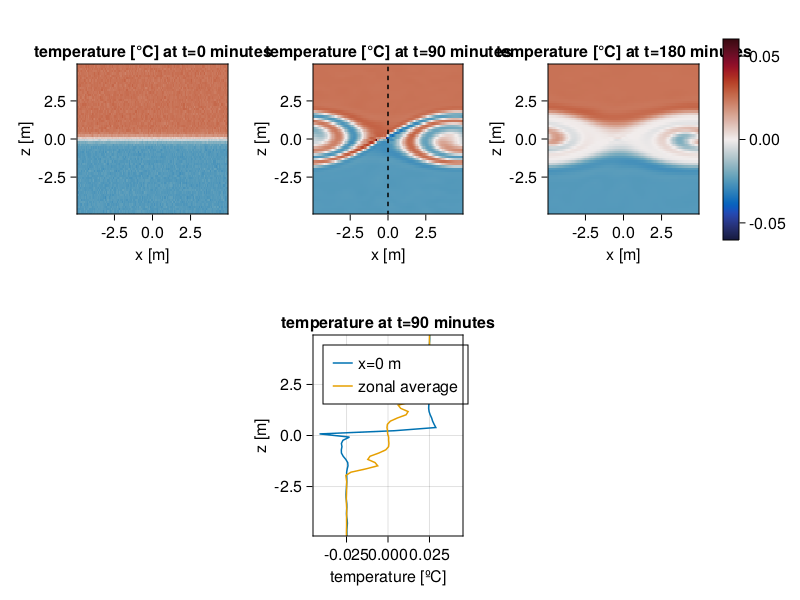

In [13]:
fig = Figure(size=(900, 600))
kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (zb[1], zb[end])), aspect=1,)
ax_B = Axis(fig[1, 1]; title = "temperature [°C] at t=0 minutes", kwargs...)
hm_B = heatmap!(ax_B, xb, zb, interior(B_timeseries, :, 1, :, 1); colorrange = B_lims, colormap = :balance)

ax_B = Axis(fig[1, 2]; title = "temperature [°C] at t=90 minutes", kwargs...)
hm_B = heatmap!(ax_B, xb, zb, interior(B_timeseries, :, 1, :, 90); colorrange = B_lims, colormap = :balance)
lines!(ax_B, [0, 0], [-5, 5], linestyle=:dash, color=:black)

ax_B = Axis(fig[1, 3]; title = "temperature [°C] at t=180 minutes", kwargs...)
hm_B = heatmap!(ax_B, xb, zb, interior(B_timeseries, :, 1, :, 180); colorrange = B_lims, colormap = :balance)

ax_B = Axis(fig[2, 2]; title = "temperature at t=90 minutes", xlabel="temperature [ºC]", ylabel="z [m]", limits=(0.75.*B_lims, (zb[1], zb[end])))
l_B = lines!(ax_B, interior(B_timeseries, 64, 1, :, 90), zb, label="x=0 m")

Colorbar(fig[1, 4], hm_B)
leg = axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots.png", fig)
#fig

l_B = lines!(ax_B, mean(interior(B_timeseries, :, 1, :, 90), dims=(1))[1,:], zb, label="zonal average")
delete!(leg)
axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots_mean.png", fig)
fig

#### Now let's try to calculate $z_{*}$ using the heaviside step function

We first need to define some xo and zo

If we choose the values where xo=-2.5 and zo=-1 we need to figure out which index in the xb array and zb array refer to these values. 

Here is my first attempt at doing this, where I found the value closest to -2.5 and -1 by hand by looking through the arrays for xo and zo respectively. This is not the best procedure.

Let's try another method, taking advantage of the absolute value function instead. Subtract our chosen value of xo from each element of the xb array. Then take the absolute value of this array and use the findmin method to find the index where the deviation from -2.5 is the smallest. Repeat for z!

Cool! We found that the value closest to -2.5 for xo is found at the 32nd index. This is the same result as above!

BUT, the computer caught my human error from the previous method. The value closest to -1 for zo is  the 26th index. 

### Now we know $x_o = 32$ and $z_o = 26$ and we can use this to calculate the Heaviside

$ H(\rho(x,t)-\rho(x_o, t)) = \left\{
\begin{array}{ll}
        0, \rho(x,t)\leq\rho(x_o, t)\\
        1, \rho(x,t)>\rho(x_o,t)\\
\end{array}
\right.$

#### Since our model outputs buoyancy values rather than density and we know $b \propto -\rho$ We can multiply both sides of the inequality by -1. 

$ H(b(x_o,t)-b(x, t)) = \left\{
\begin{array}{ll}
        0, b(x,t)\geq b(x_o, t)\\
        1, b(x,t)<b(x_o,t)\\
\end{array}
\right.$

### Now, we use the following equation to find $z_{*}$.

#### $z_{*} = \frac{\int H dV}{A} $ The integral represents the volume in the fluid where the buoyancy is less than buoyancy at 
$x_o$ Therefore, $V(b<b_o) < V_{total}$ Additionally, 
$dV = dx dy dz$ and since dy is not dependent on H, it can be taken out of the integral. Also, $A=L_x L_y$ Thus, we can cancel $L_y$ and rewrite the integral as: $z_{*} = \frac{\int H dx dz}{L_x}$

To solve the integral, we can breakdown our function and essentially take the sum of area under the curve. $\int H dA = \sum_{i,j \epsilon [0,N_x;0,N_z]} H \Delta A$ 

Here, $\Delta A = \Delta x \Delta z$ where $\Delta x = \frac{L_x}{N_x}$ and $\Delta z = \frac{L_z}{N_z}$. 

$L_x = L_z = 10$ is the prescribed length of the grid and $N_x = N_z = 128$ is the number of grid cells within the entire grid. Therefore $\Delta A = \frac{10^2}{128^2}$

### Make a plot of matrix H in the x versus buoyancy in the x


### Now, we must repeat this process for every element in xb and zb to create the vector $\vec{z_{*}}$

### Using the above method, lets create a function CreateZstar, which will return zstar for our buoyancy data

In [14]:
function CreateZstar(x, z, B)
    Δx = L/Nx
    Δz = H/Nz
    ΔA = zeros((length(x), length(z))) .+ Δx * Δz
    
    #initialize zstar
    zstar = zeros(length(x), length(z))
    for (i,x0) in enumerate(x)
        for (j,z0) in enumerate(z)
            Heavy = (B .< B[i,j])
            singlezstar = sum(Heavy .*ΔA)/L - H/2
            zstar[i,j] = singlezstar 
    
        end
    end
    
    return zstar
end


CreateZstar (generic function with 1 method)

In [27]:
B = B_timeseries


128×1×64×187 FieldTimeSeries{InMemory} located at (Center, Center, Center) on CPU
├── grid: 128×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── indices: (1:128, 1:1, 1:64)
└── data: 128×1×64×187 OffsetArray(::Array{Float64, 4}, 1:128, 1:1, 1:64, 1:187) with eltype Float64 with indices 1:128×1:1×1:64×1:187
    └── max=0.0597112, min=-0.0602668, mean=1.15388e-5

In [28]:
Zstar = CreateZstar(xb, zb, B[:,1,:,100])

print(size(Zstar))

(128, 64)

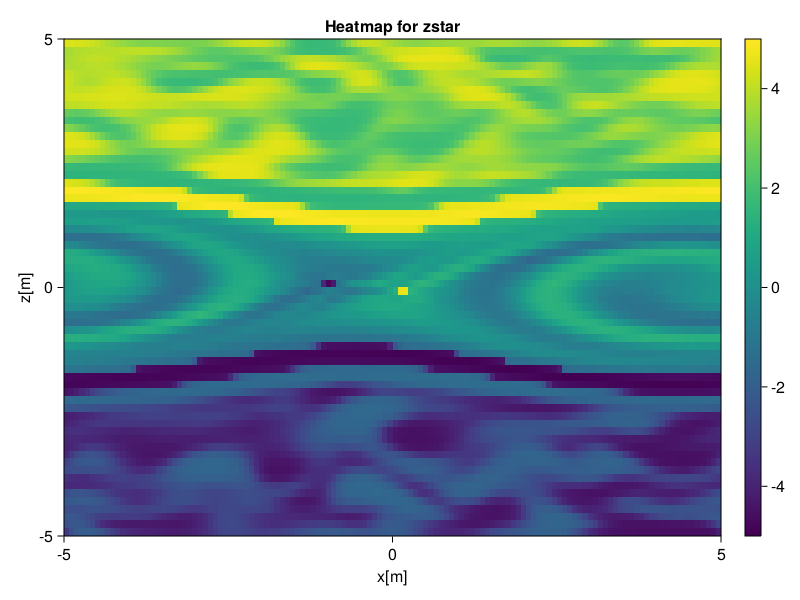

In [30]:
f1 = Figure()
ax1 = Axis(f1[1,1],title="Heatmap for zstar", xlabel="x[m]", ylabel="z[m]")
hm = heatmap!(ax1, xb,zb,Zstar)
Colorbar(f1[1, 2], hm);
f1

In [31]:
maximum(Zstar)

4.998779296875

### Let's compute Total, Background, and Available potential energies

$E_p = -\int_V b \cdot z dV $

$E_b = -\int_V b \cdot  z_* dV$

where $ dV = dx dy dz $

### we can use a similar method as the integral of the heaviside was calculated earlier

$ \Delta V = \Delta x \cdot \Delta y \cdot \Delta z  $

#### In this problem, we want to use B(t) buoyancy as it varies with time. 

In [18]:
Δx = L/Nx
Δz = H/Nz
Δy = 1
ΔV = zeros(length(xb), length(yb), length(zb)) .+ Δx * Δy * Δz;

In [19]:
tot_PE_offline = zeros(length(B.times))
#position = [xb, 1, zb]
zb_new = reshape(zb,(1,Nz))

for t in 1:(length(B.times))
    volslice = sum(-B[:,1,:,t] .* zb_new .* ΔV[:,1,:])
    tot_PE_offline[t] = volslice
end

size(tot_PE_offline)

(187,)

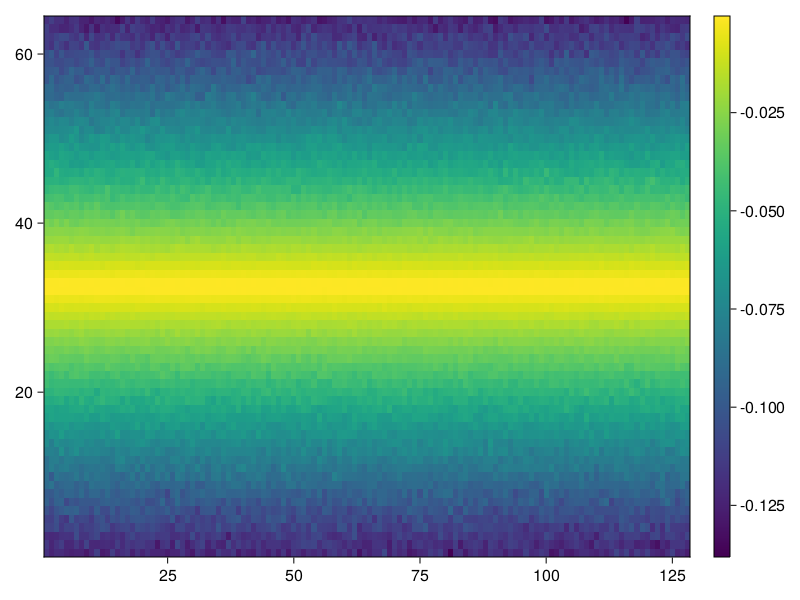

In [20]:
ff = Figure()
axff = Axis(ff[1,1])
hm = heatmap!(axff, -interior(B)[:,1,:,1].*zb_new)
Colorbar(ff[1, 2], hm)
ff

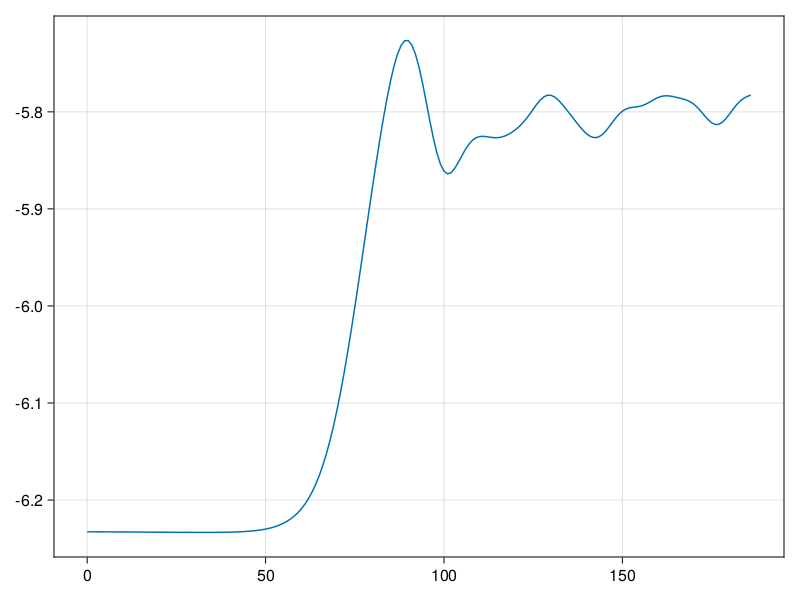

In [21]:
lines(times,tot_PE_offline) 

In [22]:
BackPE = zeros(length(B.times))

for t in 1:size(B,4)
    volslice = sum(-B[:,1,:,t] .* Zstar .* ΔV[:,1,:])
    BackPE[t] = volslice
end

In [23]:
KE_timeseries = FieldTimeSeries(filepath, "KE")
PE_timeseries = FieldTimeSeries(filepath, "PE")

times = B.times

kinetic_energy = zeros(size(times))
potential_energy = zeros(size(times))

for i = 1:length(times)
    ke_snapshot = Field(Integral(KE_timeseries[i]))
    compute!(ke_snapshot)
    kinetic_energy[i] = ke_snapshot[1,1,1]

    pe_snapshot = Field(Integral(PE_timeseries[i]))
    compute!(pe_snapshot)
    potential_energy[i] = pe_snapshot[1,1,1]
end


In [24]:
#find available potential energy

avail_PE = tot_PE_offline .- BackPE

187-element Vector{Float64}:
 -0.3465042100291953
 -0.3449246784075939
 -0.34548485606429047
 -0.3448513016902046
 -0.3433668772572016
 -0.3475168216227704
 -0.3467967273170256
 -0.3464098808876157
 -0.348175623266167
 -0.3458798117020452
 -0.3468497510405468
 -0.34624471017904135
 -0.34742590935455997
  ⋮
 -0.007762834996933421
 -0.00012929396499128387
  0.0038246042665033286
  0.0038156759942094
 -0.0004176461651059782
 -0.008416129663037175
 -0.020540979558248296
 -0.033439566801282794
 -0.047126610187714135
 -0.06139341404807119
 -0.07457453276470005
 -0.08785195004509827

In [25]:
print(length(kinetic_energy))

187

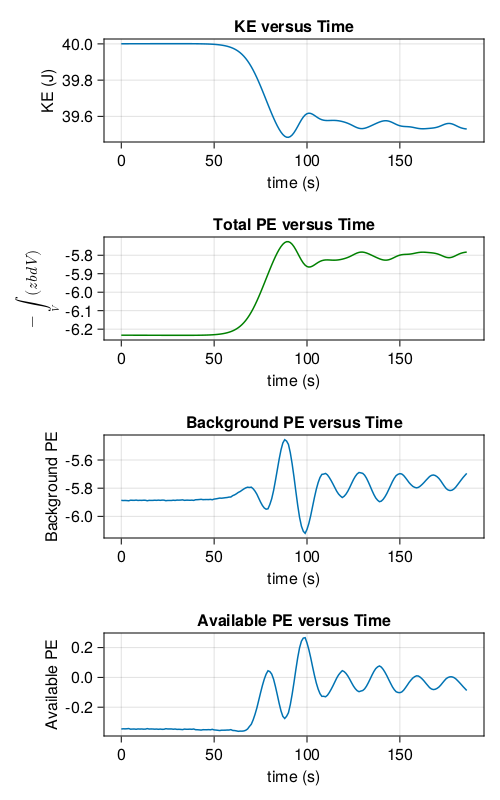

In [26]:
fig_energy = Figure(resolution = (500,800))
ax_KE = Axis(fig_energy[1,1], xlabel = "time (s)", ylabel= "KE (J)", title = "KE versus Time")
lines!(ax_KE, times, kinetic_energy)

ax_PE = Axis(fig_energy[2,1], xlabel= "time (s)", ylabel = L"-\int_V(zbdV)", title = "Total PE versus Time")
#lines!(ax_PE, times, tot_PE)
lines!(ax_PE, times, tot_PE_offline, color="green")

ax_PEb = Axis(fig_energy[3,1], xlabel="time (s)", ylabel="Background PE", title="Background PE versus Time")
lines!(ax_PEb, times, BackPE)

ax_PEa = Axis(fig_energy[4,1], xlabel="time (s)", ylabel="Available PE", title="Available PE versus Time")
lines!(ax_PEa, times, avail_PE)

fig_energy